# 2. Exploratory data analysis

In this notebook I explore the data in further detail

## 2.1. Upload packages and import data

In [2]:
import pandas as pd
import numpy as np
import copy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
# Upload datasets
df = pd.read_csv('interp_dataset.csv')
df.dropna(subset=['glc'], inplace=True)
aligned_results = pd.read_csv('aligned_results_rounded.csv')
results_frame = pd.read_csv('confusion_matrix_hypos.csv')

In [4]:
# Define interp methods
cols = ['cut_glc', 'pchip', 'linear', 'cubicspline', 'akima', 'polynomial_3',
        'polynomial_5', 'polynomial_7', 'matern', 'rq', 'rbf']

## 2.2. Data availability

In [52]:
id_frame = pd.DataFrame([i.split('_') for i in set(df.ID)], columns=['id', 'period'])

In [69]:
data_availability = pd.melt(id_frame, id_vars='id').assign(val=1).drop_duplicates().pivot('id', 'value', 'val')
data_availability

value,6months,baseline
id,,
1003,1.0,1.0
1004,1.0,1.0
1005,1.0,NaN
1007,NaN,1.0
1008,NaN,1.0
1010,1.0,1.0
1011,NaN,1.0
1012,1.0,1.0
1013,1.0,1.0


In [75]:
# Number of missing traces
data_availability.shape[0] - data_availability.count()

value
6months     24
baseline     4
dtype: int64

## 2.3. Statistical significance with chi2 test

In [5]:
results_frame.head()

,method,lv,TP,FN,FP,recall,prec,csi
0,cut_glc,all,465,36,2,0.928,0.996,0.924
1,linear,all,482,19,6,0.962,0.988,0.951
2,rq,all,484,17,11,0.966,0.978,0.945
3,rbf,all,490,11,18,0.978,0.965,0.944
4,akima,all,490,11,14,0.978,0.972,0.951


In [6]:
conf_matrix = results_frame[['method', 'lv', 'TP', 'FN', 'FP']]

In [7]:
p_list = []
for i, row in conf_matrix.iterrows():
    data = pd.DataFrame([row.values, ['glc', 'glc', (row.TP + row.FN), 0, 0]])
    data.set_index([0, 1], inplace=True)
    try:
        V, p, dof, expected = stats.chi2_contingency(data)
        p_list.append([row['lv'], row.method, p])
    except:
        print('0 error')
        continue

In [8]:
pd.DataFrame(p_list, columns=['hypo', 'method', 
                              'p-value']).sort_values(['hypo', 'method'])

,hypo,method,p-value
4,all,akima,3.851839e-06
8,all,cubicspline,6.571543e-06
0,all,cut_glc,2.870173e-09
1,all,linear,3.155975e-06
7,all,matern,1.536305e-06
6,all,pchip,4.531046e-05
9,all,polynomial_3,6.571543e-06
10,all,polynomial_5,4.144050e-06
5,all,polynomial_7,9.227503e-07
3,all,rbf,5.536615e-07


## 2.4. Distribution in duration of episodes

In [9]:
# Convert the duration of hypos to minutes
aligned_results['5_min_diff'] = pd.to_timedelta(aligned_results['5_min_diff']).astype('timedelta64[m]')
# Only need one method from aligned_results
df_results = aligned_results.loc[aligned_results['col']=='cut_glc']

In [10]:
# Set up a new dataframe for comparing the describe() metrics for each level
df_duration = pd.DataFrame()
df_duration['all'] = df_results['5_min_diff'].describe()
df_duration['lv1'] = df_results[df_results['5_min_lv2']==False]['5_min_diff'].describe()
df_duration['lv2'] = df_results[df_results['5_min_lv2']==True]['5_min_diff'].describe()

In [33]:
df_duration.round(2)

,all,lv1,lv2
count,501.00,303.00,198.00
mean,77.59,50.64,118.83
std,83.42,49.89,104.98
min,15.00,15.00,15.00
25%,30.00,25.00,51.25
50%,50.00,35.00,80.00
75%,90.00,55.00,135.00
max,635.00,405.00,635.00


In [12]:
# Number of hyps over 120 mins
df_results[df_results['5_min_diff']>120]['ID'].count()

82

In [13]:
# Prepare data for a seaborn boxplot by renaming variables
df_results['Level'] = df_results['5_min_lv2'].replace({True: 'Level 2', False: 
                                                       'Level 1'})
# Copy dataframe to add an all column to figure
df_all = copy.copy(df_results)
df_all['Level'] = 'All'
df_results_concat = pd.concat([df_results, df_all])

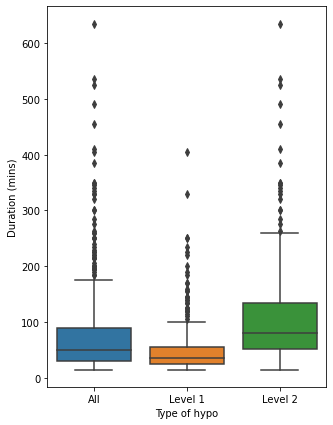

In [14]:
fig, ax = plt.subplots(figsize=(5,7))
ax = sns.boxplot('Level', '5_min_diff', data=df_results_concat, order=['All', 'Level 1', 'Level 2'])#, hue='lv2')
ax.set(xlabel='Type of hypo', ylabel='Duration (mins)')
fig.savefig('length_of_hypos_boxplot.svg')

## 2.5. Calculate RMSE

In [15]:
def metrics_calc(df, col, base_col):
    '''
    Evaluate each method using R2, RMSE and MAE and add to dataframe
    '''
    return {'Name':col,'R2':r2_score(df[base_col], df[col]), 
                             'RMSE':mean_squared_error(df[base_col], df[col], squared=True), 
                             'MAE':mean_absolute_error(df[base_col], df[col])}

In [16]:
# Delete 15 min column and leave only interp methods
df_rmse = df[pd.isnull(df['cut_glc'])].drop(columns=['cut_glc'])
df_rmse.dropna(inplace=True)
# Also delete from list of methods
interp_methods = ['pchip', 'linear', 'cubicspline', 'akima', 'polynomial_3',
                  'polynomial_5', 'polynomial_7', 'matern', 'rq', 'rbf']

In [19]:
# Declare list for results
frame_results = []
# Call metrics_calc on all of the methods to calculate accuracy
for col in interp_methods:
    frame = frame_results.append(metrics_calc(df_rmse, col, 'glc'))
# Convert to dataframe
frame  = pd.DataFrame(frame_results, columns=['Name', 'R2', 'RMSE', 'MAE'])

In [20]:
frame.sort_values('RMSE')

,Name,R2,RMSE,MAE
8,rq,0.995815,0.082220,0.125531
3,akima,0.995624,0.085962,0.125566
0,pchip,0.995623,0.085981,0.125231
1,linear,0.995579,0.086849,0.134658
2,cubicspline,0.995337,0.091609,0.126091
4,polynomial_3,0.995337,0.091609,0.126091
5,polynomial_5,0.995071,0.096833,0.130113
9,rbf,0.994593,0.106219,0.138287
6,polynomial_7,0.994577,0.106528,0.134706
7,matern,0.994453,0.108973,0.137057


In [22]:
# Calculate metrics_calc for hypoglycaemia threshold
df_hypo = df_rmse[(df_rmse.glc<4.5)&(df_rmse.glc>2.5)]
# Declare list for results
results_hypo = []
# Loop through each method to calculate accuracy vs 5 min readings
for col in interp_methods:
    frame_hypo = results_hypo.append(metrics_calc(df_hypo, col, 'glc'))
# Convert to dataframe
frame_hypo = pd.DataFrame(results_hypo, columns=['Name', 'R2', 'RMSE', 'MAE'])

In [23]:
frame_hypo.sort_values('RMSE')

,Name,R2,RMSE,MAE
2,cubicspline,0.867953,0.034112,0.102568
4,polynomial_3,0.867953,0.034112,0.102568
5,polynomial_5,0.865005,0.034873,0.105026
7,matern,0.863443,0.035277,0.104924
0,pchip,0.863110,0.035363,0.105301
6,polynomial_7,0.861547,0.035766,0.107452
3,akima,0.861050,0.035895,0.105250
9,rbf,0.858292,0.036607,0.109469
8,rq,0.852919,0.037995,0.107785
1,linear,0.837025,0.042101,0.118770


## 2.6. Precision-recall Pareto front plots

In [24]:
# Replace labels for legend of plot
names = {'cut_glc':'None', 'linear':'Linear', 
          'absexp':'GP(Abs exp)', 'akima':'Akima', 
          'matern':'GP(Matern)', 'pchip':'Pchip', 
          'rbf':'GP(RBF)', 'cubicspline':'Cubic spline', 
         'polynomial_3':'Poly 3', 'rq': 'GP(RQ)', 'polynomial_5':'Poly 5',
        'polynomial_7':'Poly 7'}
results_frame.method = results_frame.method.replace(names)
# Order of legend
hue_order = ['None', 'Linear', 'Poly 3', 'Poly 5', 'Poly 7', 'Akima',
             'Cubic spline', 'Pchip', 'GP(Matern)', 'GP(RBF)', 'GP(RQ)']
# Rename columns
results_frame.columns = ['Method', 'lv', 'TP', 'FN', 'FP', 'Recall', 'Precision', 'CSI']

In [25]:
results_frame

,Method,lv,TP,FN,FP,Recall,Precision,CSI
0,None,all,465,36,2,0.928,0.996,0.924
1,Linear,all,482,19,6,0.962,0.988,0.951
2,GP(RQ),all,484,17,11,0.966,0.978,0.945
3,GP(RBF),all,490,11,18,0.978,0.965,0.944
4,Akima,all,490,11,14,0.978,0.972,0.951
5,Poly 7,all,491,10,18,0.980,0.965,0.946
6,Pchip,all,491,10,10,0.980,0.980,0.961
7,GP(Matern),all,492,9,18,0.982,0.965,0.948
8,Cubic spline,all,492,9,15,0.982,0.970,0.953
9,Poly 3,all,492,9,15,0.982,0.970,0.953


In [26]:
# Create subsets of dataframe for all levels of hypos
lv_all = results_frame.loc[results_frame['lv']=='all'] 
lv1 = results_frame.loc[results_frame['lv']=='lv1']
lv2 = results_frame.loc[results_frame['lv']=='lv2']

In [27]:
def identify_pareto(scores):
    '''
    Function to calculate Pareto front of methods from Python for Healthcare by
    Mike Allen
    '''
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

In [28]:
def compute_pareto_coords(dataframe):
    '''
    Computes the precision-recall coordinates to plot on the plots using 
    identify_pareto
    '''
    pareto = identify_pareto(np.array(dataframe[['Recall', 'Precision']]))
    pareto_front = np.array(dataframe[['Recall', 'Precision']])[pareto]

    pareto_front_df = pd.DataFrame(pareto_front)
    pareto_front_df.sort_values(0, inplace=True)
    pareto_front = pareto_front_df.values

    x_pareto = pareto_front[:, 0]
    y_pareto = pareto_front[:, 1]
    
    return x_pareto, y_pareto

In [29]:
# Get pareto coordinates to plot on fig
x_pareto, y_pareto = compute_pareto_coords(lv_all)
x_pareto1, y_pareto1 = compute_pareto_coords(lv1)
x_pareto2, y_pareto2 = compute_pareto_coords(lv2)

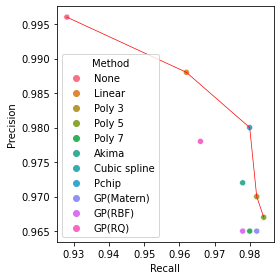

In [30]:
# Plot all hypos
fig, ax = plt.subplots(1, figsize=(4, 4))
sns.scatterplot(y=lv_all.Precision, x=lv_all.Recall, hue=lv_all['Method'], hue_order=hue_order, ax=ax)
ax.plot(x_pareto, y_pareto, color='r', linewidth=0.7)
#ax.get_legend().remove()
fig.tight_layout()
fig.savefig('pareto_all_example.svg')

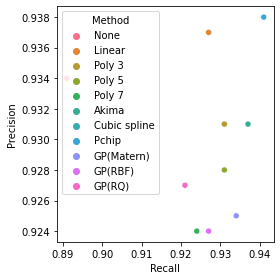

In [31]:
# Plote level 1 hypos
fig, ax = plt.subplots(1, figsize=(4, 4))
sns.scatterplot(y=lv1.Precision, x=lv1.Recall, hue=lv1['Method'], ax=ax,
                hue_order=hue_order)
ax.plot(x_pareto1, y_pareto1, color='r', linewidth=0.7)
#ax.get_legend().remove()
fig.tight_layout()
fig.savefig('pareto_lv1.svg')

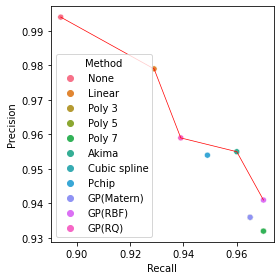

In [32]:
# Plote level 2 hypos
fig, ax = plt.subplots(1, figsize=(4, 4))
ax.plot(x_pareto2, y_pareto2, color='r', linewidth=0.7)
sns.scatterplot(y=lv2.Precision, x=lv2.Recall, hue=lv2['Method'], ax=ax,
                hue_order=hue_order)
#ax.get_legend().remove()
fig.tight_layout()
fig.savefig('pareto_lv2.svg')